<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project2/blob/master/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 2

### Iglezou Myrto - 111520170038

# Model 1

In [1]:
import pandas as pd 
from pandas import DataFrame, read_csv

Download the dataset

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv")
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [3]:
df['target'].replace({4: 1}, inplace = True)
X = df['text']
y = df['target']

## Data pre-processing

### Removing the scpecial characters

In [4]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [5]:
X = X.apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [6]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

X = X.apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
X = X.apply(lambda x: x.lower())

### Removing the upercase

In [8]:
X = X.apply(lambda x: x.lower())

## Vectorizing

In [9]:
def vectorizeData(X_train,X_test,X_val,vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_val = vectorizer.transform(X_val)
    
    return X_train,X_test,X_val

In [10]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,   random_state = 4, stratify = y)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

split_int = int(len(train_X)*0.8)

train_X, val_X = train_X[:split_int], train_X[split_int:]
train_y, val_y = train_y[:split_int], train_y[split_int:]

cv = CountVectorizer(max_features=500)
X_train, X_test, X_val =  vectorizeData(train_X, test_X, val_X, cv)

X_train = X_train.toarray()
y_train = train_y.values

X_val = X_val.toarray()
y_val = val_y.values

X_test = X_test.toarray()
y_test = test_y.values


## Batching sentences together with a DataLoader

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# bach size
batch_size = 100

# dataloader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## Architecture of NN

In [13]:
class Model_1(nn.Module):
    def __init__(self,input_size,num_classes = 1,hidden_size1 = 500,hidden_size2 = 100):
        super(Model_1, self).__init__()
     
        self.fc1 = nn.Linear(input_size,hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [14]:
def train(model,X,y,optimizer,loss_fn):

    # step 1. Zero the gradients
        optimizer.zero_grad()
    # step 2. Compute the output
        y_pred = model(X)
    # step 3. Compute the loss
        loss = loss_fn(y_pred.squeeze(), y)
    # step 4. use loss to produce gradients
        loss.backward()
    # step 5. use optimizer to take gradient step
        optimizer.step()
    
        return loss.item()

In [15]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)
  loss = loss_fn(y_pred.squeeze(), y)

  return loss.item()


In [16]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)   # sigmoid results are between [0,1], we round for prediction. e.x. 0.45 -> 0

### Function for plotting loss vs epochs

In [17]:
import matplotlib.pyplot as plt

def plot_losses(list_of_losses,valid_losses,title):
    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(list_of_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(list_of_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title(title)

    plt.show()

### train and model and then check its behavior with validation set


In [18]:
def training(net,train_loader,valid_loader,optimizer, loss_function,num_epochs = 5):

  list_of_losses = []
  valid_losses = []

  for epoch in range(num_epochs):
      running_loss = 0.0
      net.train()
      for batch_index, batch in (enumerate(train_loader)):
          x_train, y_train = batch[0], batch[1]
          x_train = x_train.float()
          y_train = y_train.float()
          
          loss_t = train(net,x_train,y_train,optimizer,loss_function)       
          running_loss += (loss_t - running_loss) / (batch_index + 1)
                
      list_of_losses.append(running_loss)

      running_loss = 0.0
      net.train()
      for batch_index, batch in (enumerate(valid_loader)):
          x_train, y_train = batch[0], batch[1]
          x_train = x_train.float()
          y_train = y_train.float()
          
          loss_t = validate(net,x_train,y_train,loss_function)       
          running_loss += (loss_t - running_loss) / (batch_index + 1)
      valid_losses.append(running_loss)
       
  return list_of_losses,valid_losses

In [38]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

def testing(net,test_loader):
  accuracy = []
  f1 = []
  recall = []
  precision = []

  for bidx, batch in (enumerate(test_loader)):
      x_test, y_test = batch[0], batch[1]
      x_test = x_test.float()
      y_test = y_test.float()
      y_test = y_test.numpy()
      y_pred = predict(net,x_test)
      y_pred = y_pred.detach().numpy()
      
      acc = accuracy_score(y_test, y_pred)
      f1_sc = f1_score(y_test, y_pred, average='macro')
      rec = recall_score(y_test, y_pred, average='macro')
      prec = precision_score(y_test, y_pred, average='macro')
      
      accuracy.append(acc)
      f1.append(f1_sc)
      recall.append(rec)
      precision.append(prec)

  return np.mean(accuracy),np.mean(f1),np.mean(recall),np.mean(precision)
    

# Training



In [44]:
df = pd.DataFrame(columns=[['Optimizer','Loss Function','Accuracy','F1-score','Recall-score','Precision']])

## **Optimizer**: Adam, **Loss Function**: MSELoss

In [45]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.Adam(net.parameters(), lr=learning_rate)
lf = nn.MSELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

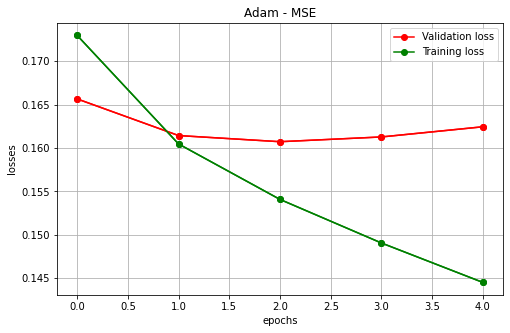

In [46]:
title=("Adam - MSE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [47]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["Adam","MSE",acc,f1,recall,precision]

## **Optimizer**: SGD, **Loss Function**: MSELoss

In [48]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.SGD(net.parameters(), lr=learning_rate)
lf = nn.MSELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

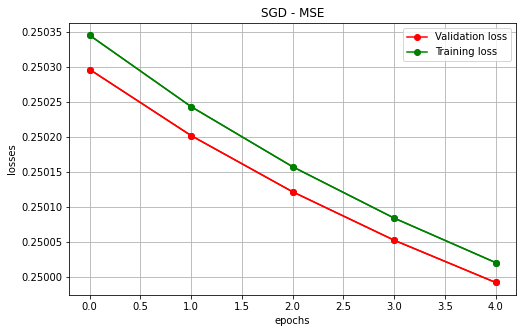

In [49]:
title=("SGD - MSE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [50]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["SGD","MSE",acc,f1,recall,precision]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Optimizer**: RMS, **Loss Function**: MSELoss

In [51]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.MSELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

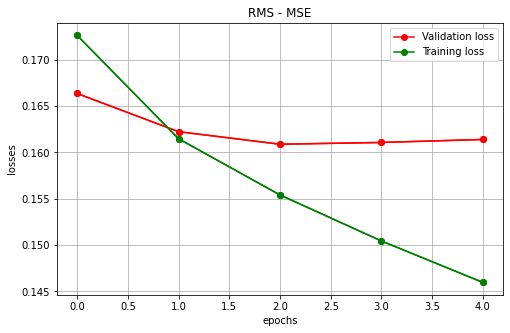

In [52]:
title=("RMS - MSE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [53]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["RMS","MSE",acc,f1,recall,precision]

## **Optimizer**: Adam, **Loss Function**: BCELoss

In [54]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.Adam(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

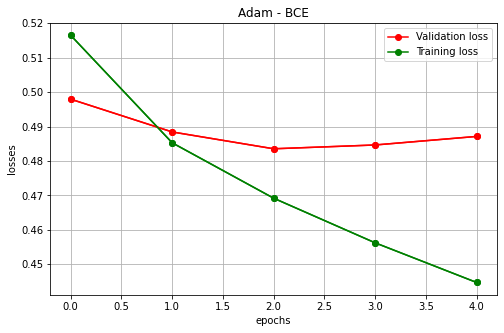

In [55]:
title=("Adam - BCE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores


In [56]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["Adam","BCE",acc,f1,recall,precision]

## **Optimizer**: SGD, **Loss Function**: BCELoss

In [57]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.SGD(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

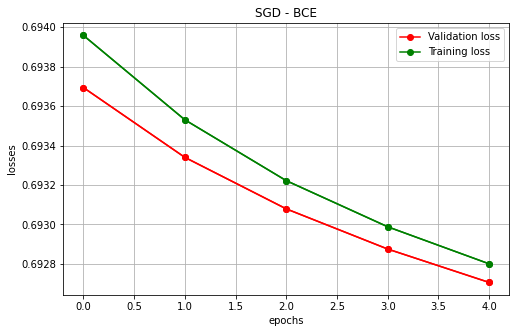

In [58]:
title=("SGD - BCE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [59]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["SGD","BCE",acc,f1,recall,precision]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Optimizer**: RMS, **Loss Function**: BCELoss

In [70]:
learning_rate = 0.0001
net = Model_1(len(X_train[0])) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

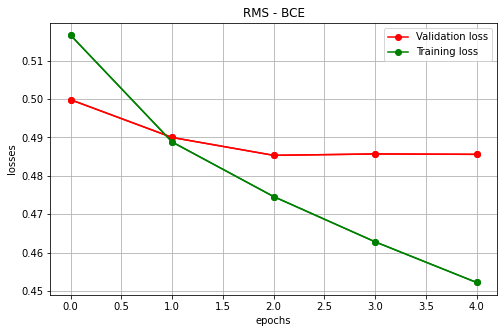

In [61]:
title=("RMS - BCE")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [62]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["RMS","BCE",acc,f1,recall,precision]

# **Scores**

In [65]:
df

,Optimizer,Loss Function,Accuracy,F1-score,Recall-score,Precision
0,Adam,MSE,0.763786,0.761981,0.763787,0.764218
1,SGD,MSE,0.500570,0.333380,0.500094,0.265431
2,RMS,MSE,0.765078,0.763278,0.765062,0.765230
3,Adam,BCE,0.764760,0.762914,0.764800,0.764798
4,SGD,BCE,0.502242,0.348534,0.502732,0.482573
5,RMS,BCE,0.765956,0.764171,0.765889,0.766045


# **Remarks** 



*   For this neural network we used:
> *  An input Linear layer with size of the feature, which uses
the ReLU activation function.
> * A second Linear hidden layer with 500 neurons, which uses
the ReLU activation function.
> * A third, that takes an input with size 200 and has an output of 1, because of the binary classification, and uses logistic function as activation function.

*   We experiment with different kind of optimizers and loss functions.
*   In the final scores we observe great results with both Adam and RMS. The loss functions, as expected, don't play a masive role on the results.
*   Models with SGD have really low scores.
*   The best scores, close to 76.5%, are received with RMS optimizer and BCE as loss function. In the plot of loss vs epoch we observe that the model does not overfit, since the validation loss after 2 epochs reamains stable.

# **Best Model**

After running all the models in the three notebooks we conclude that the best was Model_1 with RMS optimizer and BCE as loss function and 76.5% score. 


## **ROC-Curve** 
*This function is taken from a previous work done with a partner*

In [ ]:
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from numpy import interp
from itertools import cycle

def create_ROCplot(n_classes,predictions,y_test,title):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    classes = [0,1]

    plt.figure(figsize=(8,5))
    plt.grid()
    

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2

    plt.plot(fpr["macro"],tpr["macro"],label='macro-average ROC curve ',
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,lw=lw,label='Class - {0} '.format(classes[i]))

   
    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
   
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title,fontsize=20,fontweight='bold')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
batch_size = len(test_data)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

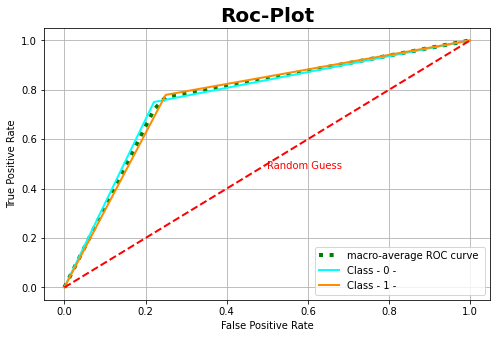

In [ ]:
for bidx, batch in (enumerate(test_loader)):
  x_test, y_test = batch[0], batch[1]
  x_test = x_test.float()
  y_test = y_test.float()
  y_test = y_test.numpy()
  y_pred = predict(net,x_test)
  y_pred = y_pred.detach().numpy().reshape(-1)
  create_ROCplot(2,y_pred,y_test,'Roc-Plot')   

## Remarks for ROC-curve 


The ROC curve of a good classifier is closer to the top left of the graph, because in a good classifier, we can achieve high TPR at low FPR.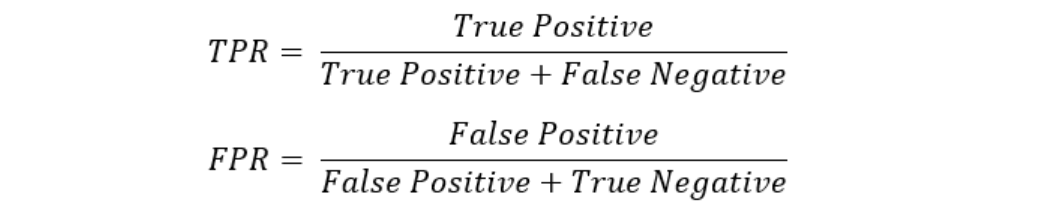

In our case, we can conlude from the plot that our classifier is nice and it able to distinguish the two classes well.  


In an ROC Curve, the diagonal represents the baseline model/random classifier. The closer an ROC curve comes to the 45-degree diagonal of the ROC space, the less powerful is the model.

The area under the ROC Curve is also known as AUC. AUC provides an aggregate measure of performance of a model across all possible classification thresholds. AUC represents a degree or measure of separability. It tells us how much the model is capable of distinguishing between classes.

The curves of the classes are in a nice level, but not the best, because they are in the midle of random curve and left corner. Class 1 is a little bit higher,with greater AUC, so we can conclude that TPR went a little better in that case.


## **Comparison with logistic regression from HW 1**

In the previous project the best score detected was close to 78%, which is greater than 76% of this project.

Neural networks are somewhat related to logistic regression. Basically, we can think of logistic regression as a one layer neural network.

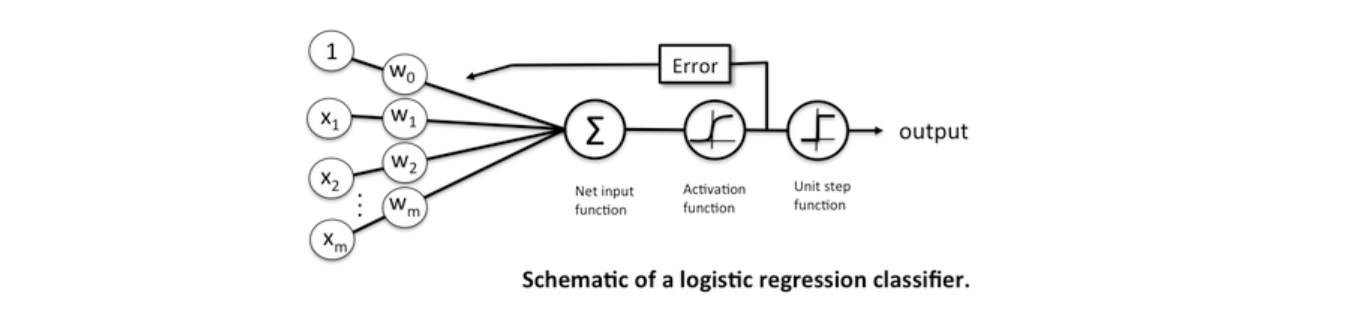

One of the nice properties of logistic regression is that the logistic cost function is convex, and thus we are guaranteed to find the global cost minimum. But, once we stack logistic activation functions in a multi-layer neural network, we’ll lose this convexity. 

Neural network and logistic regression are two different techniques  to do the same thing, classification of data.

Logistic regression is a statistical approach while Neural network mimics the brains neuron network concept. When you use sigmoid activation function in neural network it behaves like logistic regression. Since linear regression is a "part" of the neural network, is a simplest technique that requires less time to display the desired results but these results are close to neural network's. 
So the scores should be similar.

## References



*   https://github.com/ShalyginaA/imdb-sentiment-analysis-with-pytorch/blob/master/imdb_analysis.ipynb
*   https://sebastianraschka.com/faq/docs/logisticregr-neuralnet.html

